# doc2vec and t-SNE/MDS to cluster business classifications

Here we will use the data collected from Companies House in an attempt to use some unsupervised learning to uncover common topics and themes. We will encode the documents using doc2vec - an extension of the well known word2vec encoding. Once we have encoded the data, we will use some dimensionalty reduction to visualise the data in 2D or 3D in the hope we see some clusters starting to emerge. 

## Load Modules

In [1]:
%matplotlib inline

import os
import string
import operator
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn import manifold
from sklearn.cluster import KMeans
import random
import hdbscan
import seaborn as sns
from scipy.spatial import KDTree

LabeledSentence = gensim.models.doc2vec.LabeledSentence

dir_path = '/home/mike/Exploratory/'

## Label data & convert into a list

In [98]:
# label data by its filename

docLabels = []
docLabels = [f for f in os.listdir(dir_path)] 

docLabels1 = []
docLabels1 = [f for f in os.listdir(dir_path)] 

# load data into a list of strings

data = []
data1 = []
data_length = []

for doc in docLabels:
    text = open(dir_path + doc, 'r')
    data.append(text.read())
    data1.append(text.read())
    text.close()  

# convert data to lowercase

for i in range(0,len(data)):
    data[i] = ' '.join(data[i].split())
    data[i] = data[i].lower()
    data1[i] = ' '.join(data[i].split())
    data1[i] = data[i].lower()

# get rid of data with less than 40 characters - likely a poor OCR result or similar
# delete associated labels     
    
indexes = []
indexes1 = []

for i in range(0,len(docLabels)):
    if len(data[i]) < 41:
        indexes.append(i)

for i in sorted(indexes, reverse=True):
    del docLabels[i]
    
for i in range(0,len(docLabels1)):
    if len(data1[i]) < 41:
        indexes1.append(i)

for i in sorted(indexes1, reverse=True):
    del docLabels1[i]
    
data = [f for f in data if len(f) > 40]
data1 = [f for f in data1 if len(f) > 40]

data = [f.translate(None, string.punctuation) for f in data]
data1 = [f.translate(None, string.punctuation) for f in data1]
  
# get a flavour of the distribution of description lengths 

for i in range(0,len(data)):
    data_length.append(len(data[i]))


Examples of the data. We want to cluster businesses together based on how they descibe themselves.  

In [156]:
for i in range(10):
    print '{0}'.format(i) + '. ' + data[i]

0. principal activities blythe utilities limited is a miltutility infrastructure provider involved in the design and construction of utility networks and infrastructure direct to commercial and residential developers throughout scotland and the north of england
1. and activities rural action yorkshire is an independent voluntary and charitable organisation that has been working to help improve the quality of life for people living and working in yorkshires rural areas since 1937
2. principal activities ‘ the principal activity of the company continued to be that of designing installing
3. principal activity the principal activity of the company is that of property ownership
4. principal activities and business review the principal activity of the company continues to be that of a hotel booking agent
5. of activity to increase in the forthcoming year with greater emphasis on developing enquiries and converting these to orders
6. principal activities the company’s principal activity duri

## Visualise string length distribution of descriptions

<function matplotlib.pyplot.show>

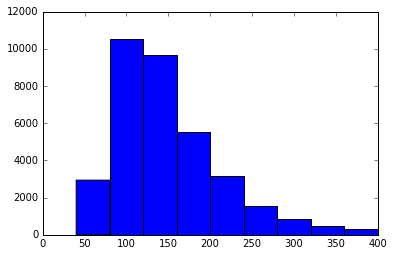

In [4]:
plt.hist(np.asarray(data_length), np.linspace(40,400,10))
plt.show

Some extracts have more than 300 characters. This is likely the result of either a poor OCR, but more likely a report which doesn't contain a full stop which was the criteria for the Regex stopping in the text extraction algorithm. In this case, we'll just take the first 300 characters - this will likely aid doc2vec as it'll prune unwanted information. 

## Some preprocessing 

<function matplotlib.pyplot.show>

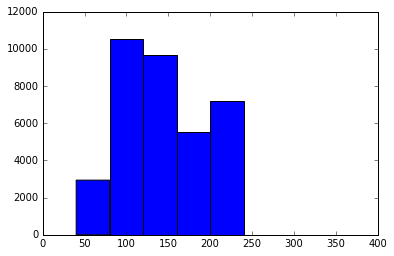

In [5]:
for i in range(0,len(data)):
    if data[i] > 200:
        data[i] = data[i][0:200]

data_length = []

for i in range(0,len(data)):
    data_length.append(len(data[i]))
    
plt.hist(np.asarray(data_length), np.linspace(40,400,10))
plt.show

It may be that this range is still too large - we will investigate this later. 

Most of the information is likely to be unimportant as well. Most sentences will contain things such as 'principal activity', 'company', 'directors', etc. We'll create a small bank of stopwords to trim the fat. There isn't really any need to do anything like stemming as the sentences are too small anyway. 

## Some more preprocessing

In [6]:
StopWords = ["principal", "principle", "activity", "activities", "'", "`", "s", "company", "is", "that", "of", "a", "continued", "the", "and", "lp", "to", "was", "not", "business", "review", "limited", "ltd", "ltd.", "group", "during", "year", "as", "to", "be", "company's", ".", ",", "sale", "an"]

for i in range(0,len(data)):
    data[i] = ' '.join([word for word in data[i].split() if word not in StopWords])



Now we can try running the doc2vec algorithm on the processed data. In this case it will encode the data into a 300-dimensional vector. The hope here is that if we take the cosine distance between the resulting vectors, there **could** be a clustering around similar topics. 


## doc2vec algorithm, encoding into 300-dimensional vector space

In [7]:
class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
       self.labels_list = labels_list
       self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(),tags=[self.labels_list[idx]])

it = LabeledLineSentence(data, docLabels)

model = gensim.models.Doc2Vec(size=400, window=10, min_count=2, workers=4,alpha=0.025, min_alpha=0.001) # use fixed learning rate
model.build_vocab(it)
for epoch in range(10):
    model.train(it, total_examples=len(data), epochs = 50)
    model.alpha -= 0.002 # decrease the learning rate

In [8]:
# save the model 

model.save('/home/mike/doc2vec.model')

## Exploring the model

We can for example throw some phrases into our trained model. This infers a vector which can be compared the the vectors already in the model. Below is a simple example where we insert the phrase "property investment management" into the model and see which 5 descriptions are most similar. 

The top result gives "principal activity is that of property investment and management." which is a nice result. Based on this principal, if the model is picking up the underlying themes/topics in the descriptions,  if we apply a clustering algorithm to our document vector, hopefully some interesting topic clustering will emerge. 

The first thing we can try is dimensionality reduction - if we have a nice visualisation for our data in 2D or 3D, we may be able to see clusters straight away - assuming the dimensionality reduction is actually a valid representation of the data. Some things to try may by multidimensional scaling, t-SNE, perhaps PCA/SVD just to get a feel for the variability/dimensionality. 

In [10]:
tokens = "property investment management".split()

topic = model.infer_vector(tokens)
similar_documents = model.docvecs.most_similar([topic], topn=5)

# print similar_documents

for i in range(0,5):
    holder = open(dir_path+similar_documents[i][0], 'r').read()
    print '{0}'.format(i) + '. ' + ' '.join([word for word in holder.split()])


[('01540837.txt', 0.5419797897338867), ('01728128.txt', 0.5400545597076416), ('OC345960.txt', 0.5303000211715698), ('OC354068.txt', 0.5290272831916809), ('00404353.txt', 0.5287789702415466)]
0. Principal activities The principal activity of the company during the year was property investment and management.
1. Principal activities The principal activity of the company was that of property investment and management.
2. principal activity is that of property investment and management.
3. PRINCIPAL ACTIVITIES Artemis Investment Management LP is a limited liability partnership incorporated and domiciled in England, registration number OX354068.
4. PRINCIPAL ACTIVITIES The principal activities of the company during the year was that of a property investment and management company.


In [50]:
# extract document vectors

doc_vecs = [None]*400

subset = random.sample(xrange(0,len(data)),5000)

for i in subset:
    doc_vecs = np.vstack([doc_vecs, model.docvecs[i]])
    
doc_vecs = np.delete(doc_vecs, (0), axis=0)

In [51]:
print doc_vecs.shape

(5000, 400)


## Try t-SNE & MDS

So now we have the documents encoded into 35,868 x 50 matrix. One idea would be to take the cosine distance between all of the vectors and use multidimensional scaling on the resulting distance matrix to construct points in 2D or 3D that preserve the distances. Another idea will be to use t-SNE which minimises the Kullback-Liebler divergence between two distributions. We'll try both. 

Obviously to construct a distance matrix of the pairwise distances between every vector would take a lot of memory. We'll try MDS first, then t-SNE on a random subset (n=10,000) of the data. 

In [52]:
# compute distance matrix

D = squareform(pdist(doc_vecs, 'cosine'))

D = D/np.max(D)

In [53]:
print np.max(D)

1.0


In [157]:
MDS = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)

In [158]:
result = MDS.fit(D)
coordinates = result.embedding_

<function matplotlib.pyplot.show>

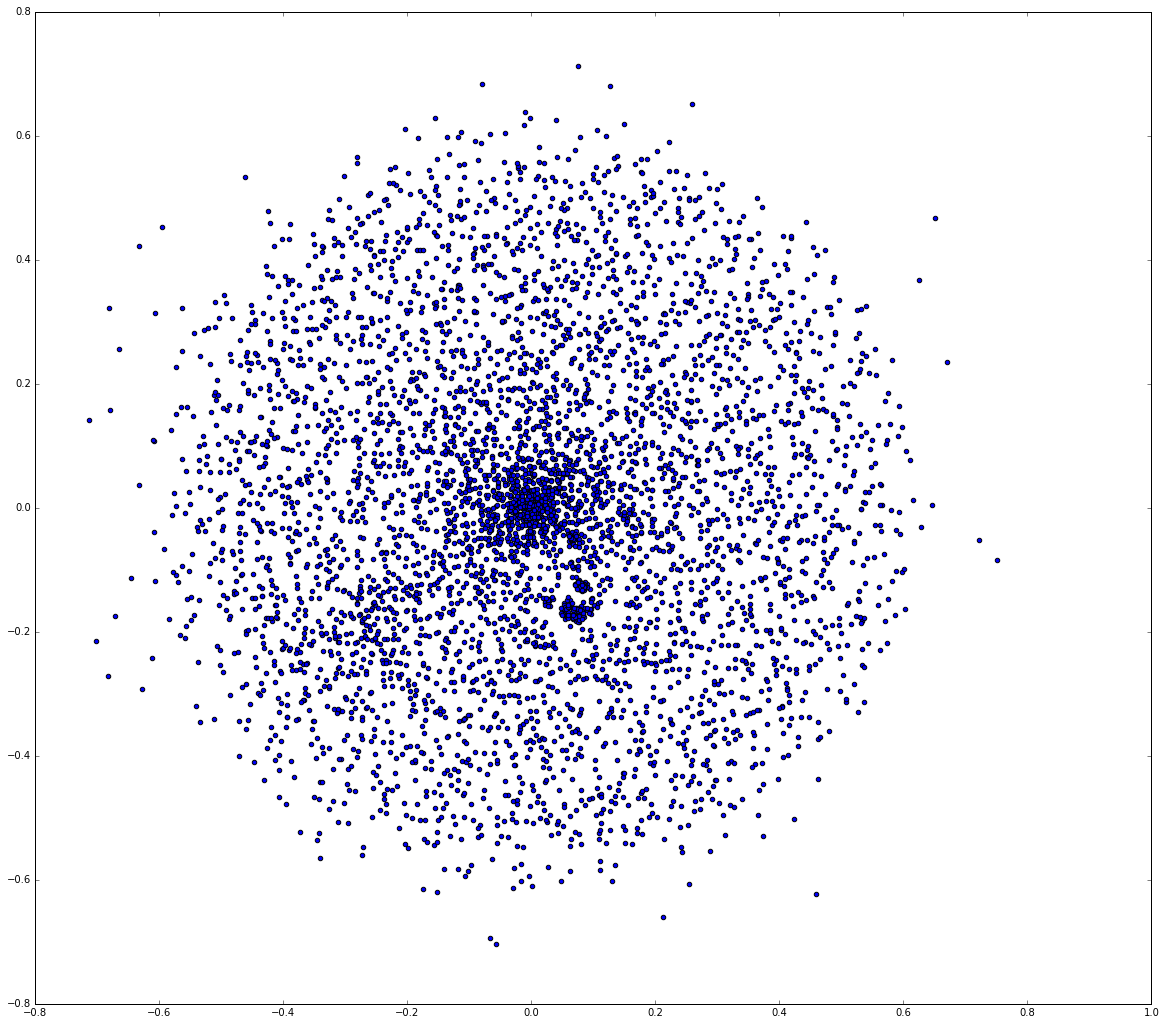

In [160]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coordinates[:, 0], coordinates[:, 1], marker = 'o')
plt.gcf().set_size_inches(20,20)
plt.gca().set_aspect('equal')
plt.show

This isn't so good, no obvious clusters show up. Expect t-SNE to be better, though. Or perhaps different distance metric? 

In [54]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=6)

X_tsne = tsne.fit_transform(doc_vecs)


In [55]:
D_tsne = tsne.fit_transform(D)

<function matplotlib.pyplot.show>

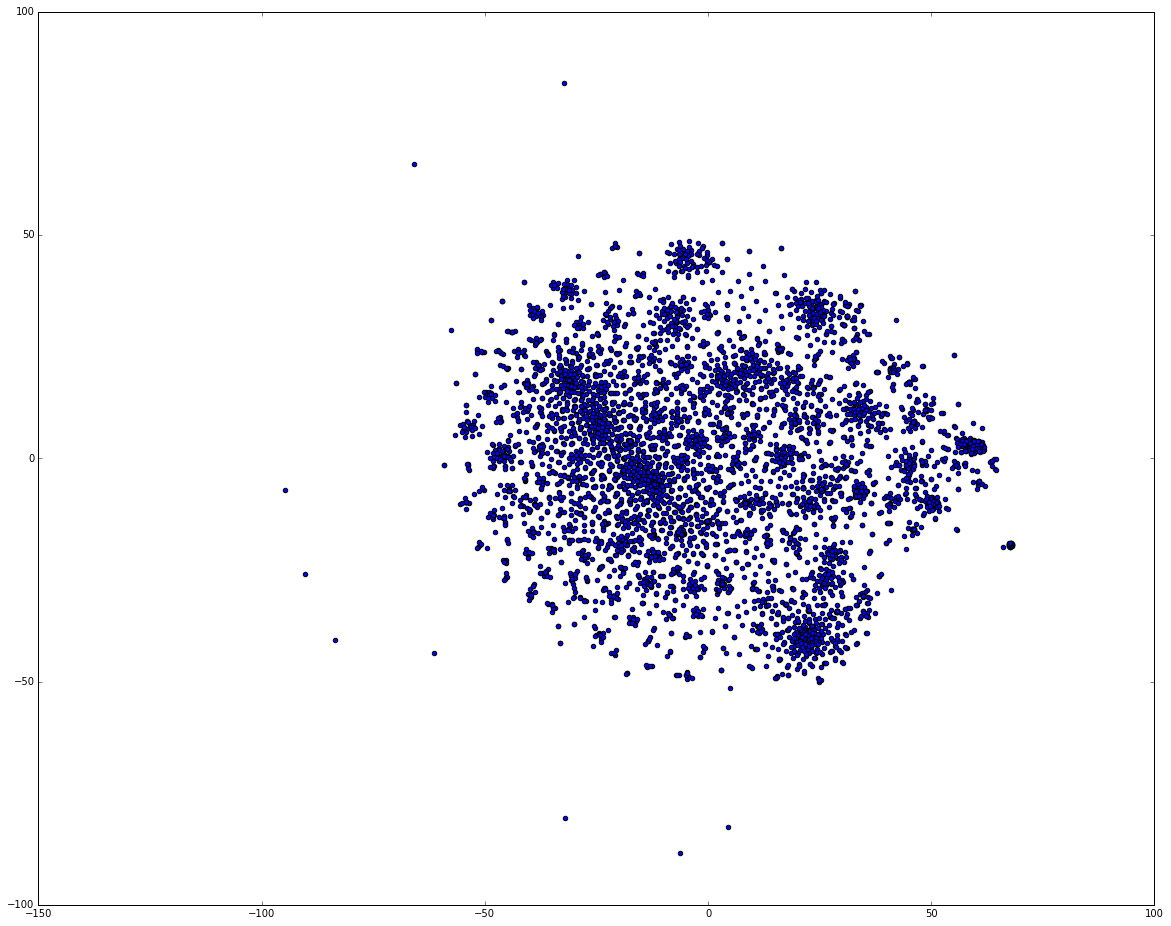

In [56]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker = 'o')
plt.gcf().set_size_inches(20,20)
plt.gca().set_aspect('equal')
plt.show

Much better! A lot of small clusters are showing up. From here we can identify the documents closest to the k-means centroids to find topics/themes. We could do further clustering on each of the clusters to identify sub-topics etc. 

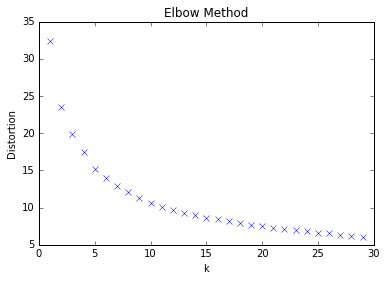

In [57]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_tsne)
    distortions.append(sum(np.min(cdist(X_tsne, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tsne.shape[0])
 
plt.plot(K, distortions, 'bx')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


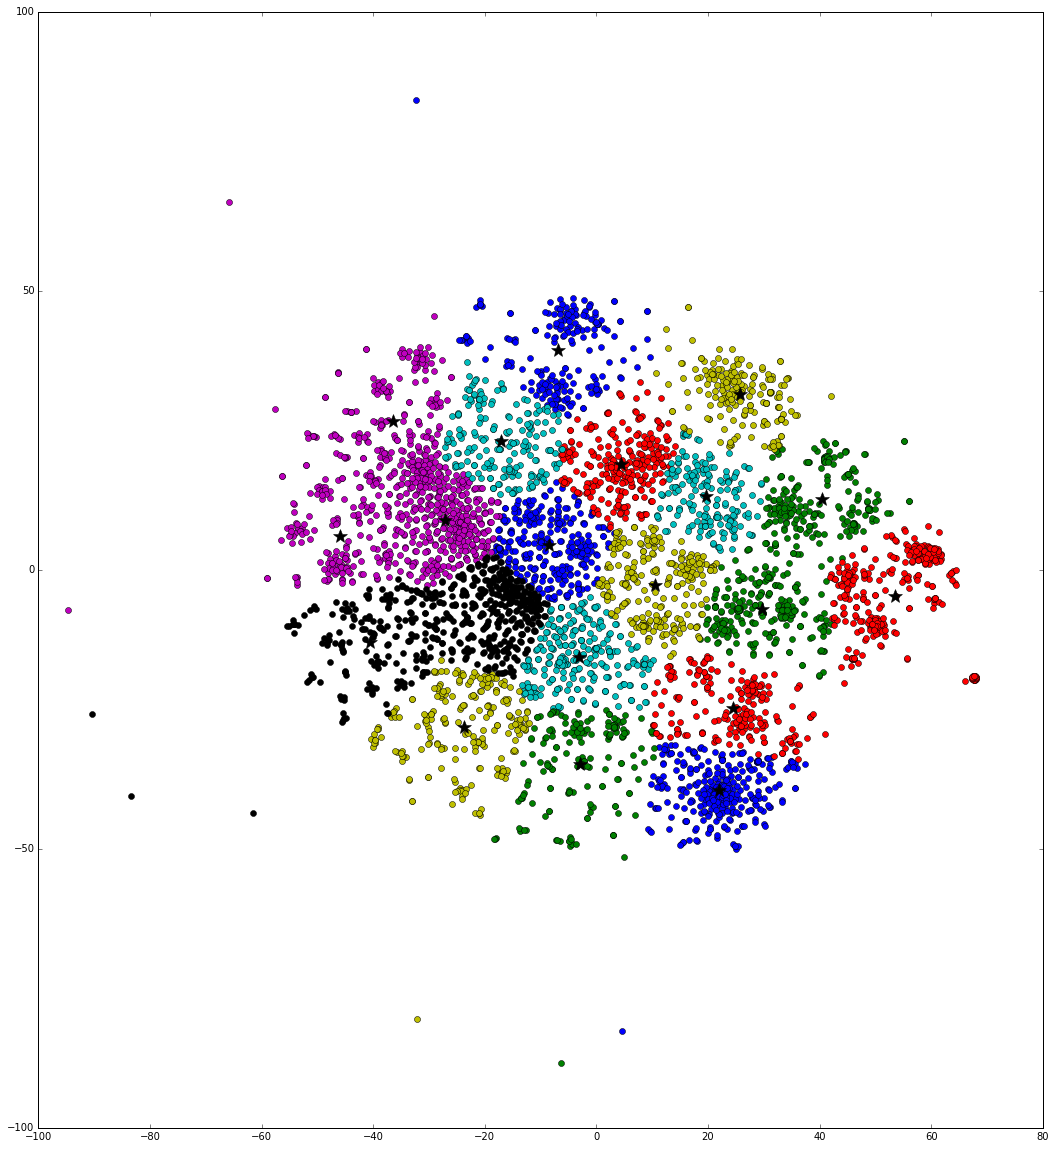

In [58]:
k = 20

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_tsne)

labels = kmeans.labels_
centroids_X = kmeans.cluster_centers_

for i in range(k):
    ds = X_tsne[np.where(labels==i)]
    plt.plot(ds[:,0],ds[:,1],'o')
    
plt.plot(centroids_X[:,0], centroids_X[:,1], '*', markersize=15)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(20,20)
plt.show()

<function matplotlib.pyplot.show>

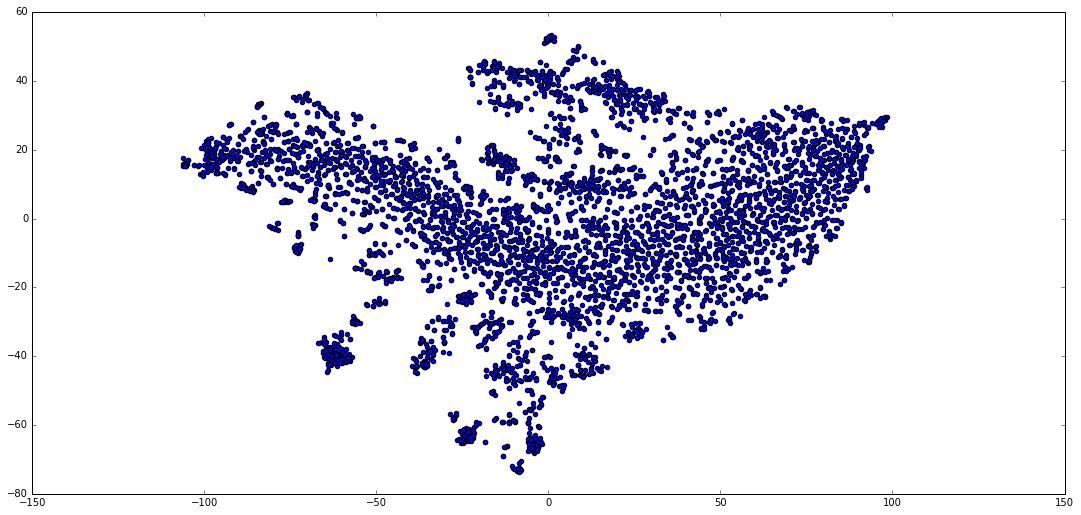

In [59]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(D_tsne[:, 0], D_tsne[:, 1], marker = 'o')
plt.gcf().set_size_inches(18.5, 10.5)
plt.gca().set_aspect('equal')
plt.show

Dimensionality reduction of the distance matrix suggests a bird of peace. 

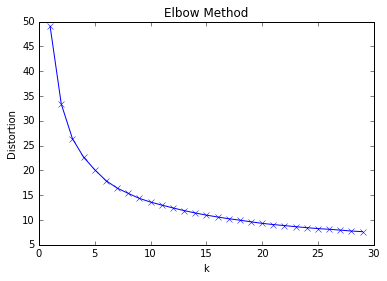

In [60]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(D_tsne)
    distortions.append(sum(np.min(cdist(D_tsne, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / D_tsne.shape[0])
 
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

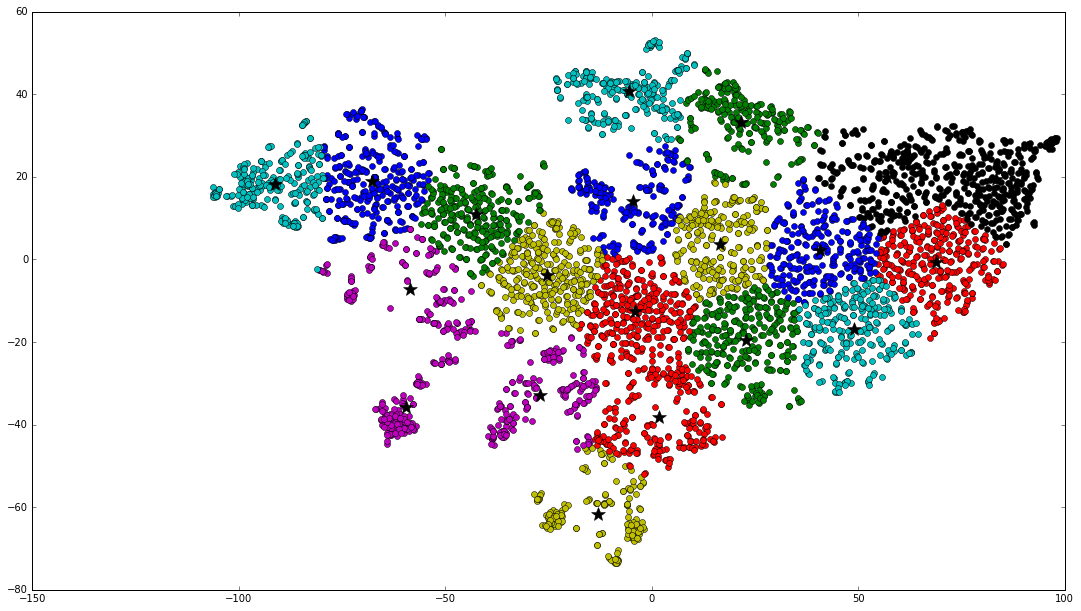

In [61]:
k = 20

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(D_tsne)

labels = kmeans.labels_
centroids_D = kmeans.cluster_centers_

for i in range(k):
    ds = D_tsne[np.where(labels==i)]
    plt.plot(ds[:,0],ds[:,1],'o')
plt.plot(centroids_D[:,0], centroids_D[:,1], '*', markersize=15)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

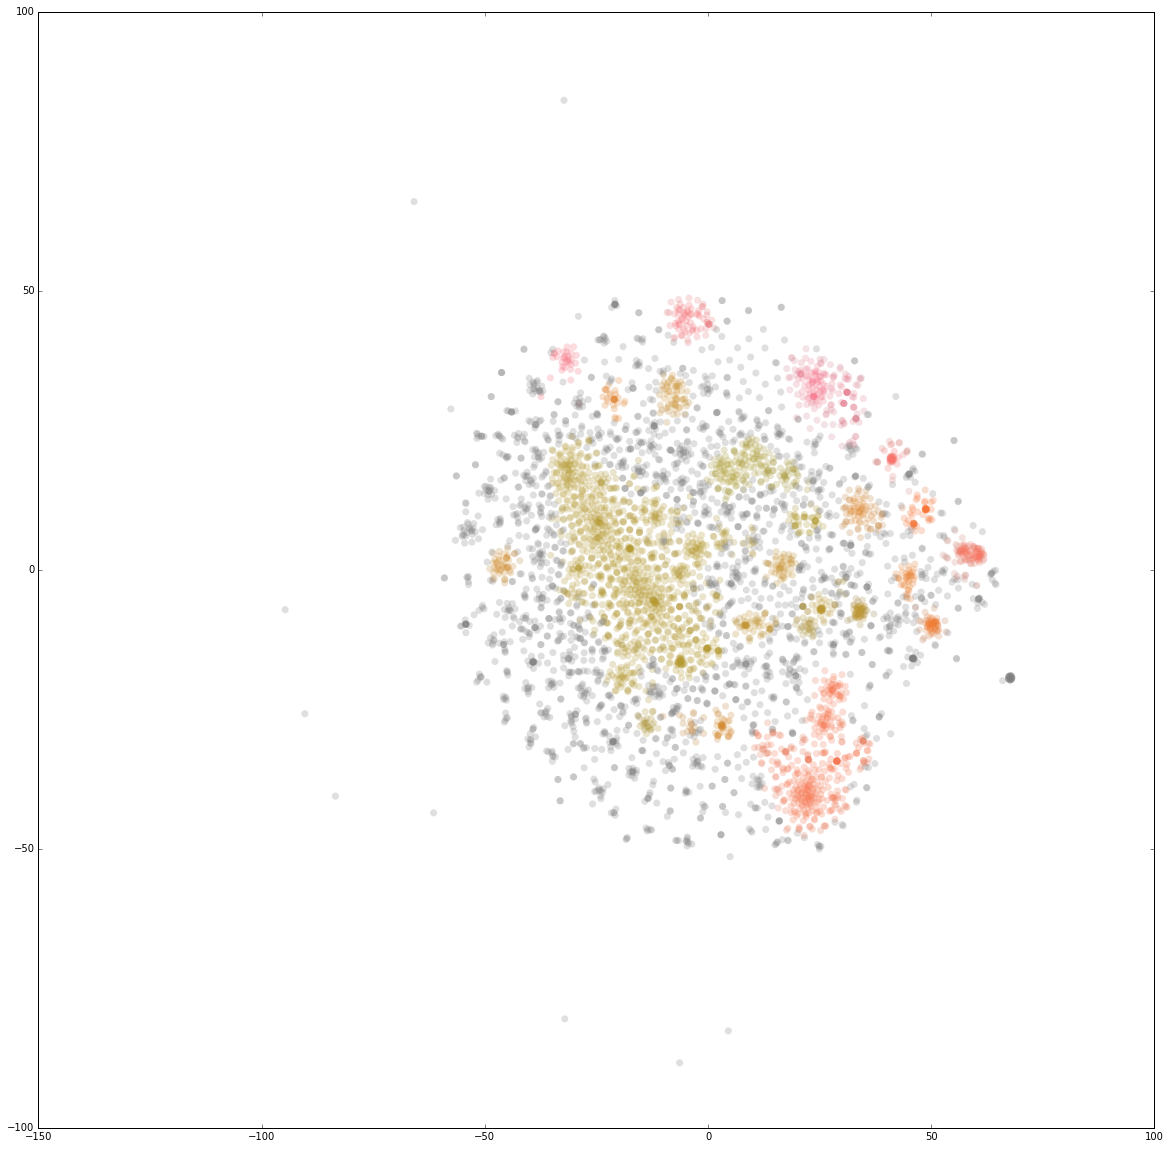

In [69]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25).fit(X_tsne)
color_palette = sns.color_palette('husl', 100)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X_tsne.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.gcf().set_size_inches(20,20)

In [87]:
print clusterer.labels_.max()

20


This is nice, the strength of colour indicates cluster centres. We can investigate the document topics based around these centres and see if it makes any sense. 

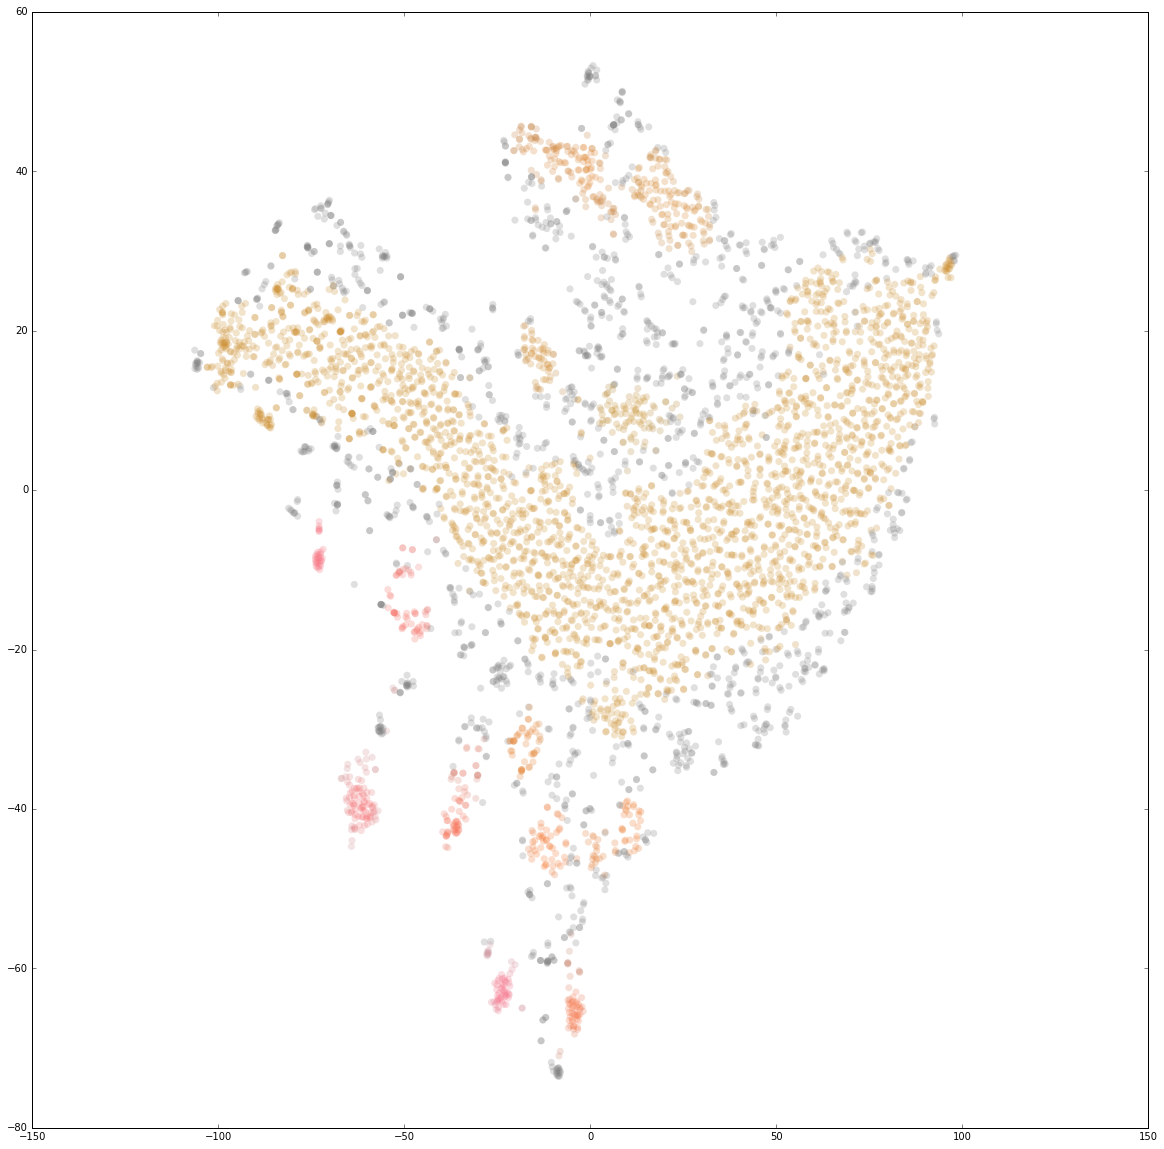

In [71]:
clusterer1 = hdbscan.HDBSCAN(min_cluster_size=25).fit(D_tsne)
color_palette = sns.color_palette('husl', 95)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer1.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer1.probabilities_)]
plt.scatter(*D_tsne.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.gcf().set_size_inches(20,20)

In [72]:
print clusterer1.labels_.max()

13


Perhaps the distance matrix isn't so useful here. Too noisy? 

## Investigate the clustering 

We can now investigate the documents near the cluster centres. This **might** give us insight into potential SIC classifications. The k-means clustering is pretty crude, the centroids may not give a very accurate picture of the data, I would imagine the HDBSCAN centres are more indicative; but we'll take a look at both. 

In [139]:
tree = KDTree(X_tsne)
dist, idxs = tree.query(centroids_X[0], 5)

for x in idxs:
    print data1[subset[x]]

principal activity and business review the companys principal business is that of the procurement manufacture and distribution of quilts pillows and various other home furnishing products to the retail sector
principal activity  the principal activity of the company is the sale of australian coach tours and other holiday arrangements
principal activity of the company continued to be that of the provision of skilled resource most notably engineers to the major automotive em’s and other business sectors
principal activity our principal activity during the year was road freight transport in particular the transportation of bulk spirit other liquids and packaging
principal activities the principal activity of the company continues to be the manufacturing of seat structures window regulators door modules and other mechanisms for the automotive industry


Not so good? Manufacture/engineering? 

In [145]:
tree = KDTree(X_tsne)
dist, idxs = tree.query(centroids_X[1], 5)

for x in idxs:
    print data1[subset[x]]

principal activities review of the business and financial objectives the principal activity of the company during the year was the management and development of the group’s property assets for use by the group’s subsidiary undertakings
principal activity the principal activity of the company is to act as a property development and investment company
principal activity the principal activity of the company is to act as a property development and investment company
principal activity of the company during the year and for the foreseeable future is property investment and development
principal activities and review of the development of the business the principal activity of the company is to act as investment adviser to its parent company beguiler limited a specialist wealth manager registered with the guernsey financial services commission dedicated to developing bespoke and innovative solutions for private clients


In [154]:
tree = KDTree(X_tsne)
dist, idxs = tree.query(centroids_X[2], 5)

for x in idxs:
    print data1[subset[x]]

principal activities and business review the principal activity of the company during the year was the provision of consultancy engineering services to the oil and gas industry
principal activities the principal activity of the company is the provision of information technology consultancy services
principal activity the principal activity of the company continues to be that of the provision of marketing and promotion consultancy services
principal activity the principal activity of carson mcdowell lp is the provision of legal services as regulated by the law society of northern ireland
principal activity is the provision of spot hire and long term rental of commercial vehicles


k-means seems a bit hit and miss. 

In [149]:
new_list = []

for i in range(0,5000):
    if clusterer1.labels_[i] == 0:
        new_list.append(subset[i])

for i in range(0,5):
    print data1[new_list[i]]

principal activity of the company is to act as an investment holding company
principal activity of the company is that of an investment holding company
principal activity the company is an investment holding company
principal activity of the company is that of an investment holding company
principal activity the principal activity of the company is to act as an investment holding company


In [150]:
new_list = []

for i in range(0,5000):
    if clusterer1.labels_[i] == 1:
        new_list.append(subset[i])
        
for i in range(0,5):
    print data1[new_list[i]]

principal activity the principal activity of the company is an intermediate holding company
principal activities the principal activity of the company during the year was that of an intermediate holding company
principal activities the principal activity of the company during the year was that of an intermediate holding company
principal activity of the company is that of an intermediate holding company
principal activity the principal activity of the company is that of an intermediate holding company


In [151]:
new_list = []

for i in range(0,5000):
    if clusterer1.labels_[i] == 2:
        new_list.append(subset[i])

for i in range(0,5):
    print data1[new_list[i]]

principal activity the principal activity of the company is that of a holding company
principal activity the principal activity of the company is that of a holding company
principal activities the principal activity of the company is that of a holding company
principal activities the principal activities of the company in the year under review were those of a holding company
principal activities the principal business of the company is as a holding company


In [152]:
new_list = []

for i in range(0,5000):
    if clusterer1.labels_[i] == 3:
        new_list.append(subset[i])

for i in range(0,5):
    print data1[new_list[i]]

principal activities the company’s principal activity is the manufacture and sale of washroom systems
principal activities the company’s principal activity continued to be management lease and charter of maritime vessels together with related marine services
principal activities the companys principal activity during the year continued to be the design and manufacture of heat ex changers and cooling equipment
principal activity and review of the business the company’s principal activity during the year continued to be the manufacture and sale of parestressed concrete products
principal activity the companys principal activity is that of an employment agency


In [153]:
new_list = []

for i in range(0,5000):
    if clusterer1.labels_[i] == 4:
        new_list.append(subset[i])

for i in range(0,5):
    print data1[new_list[i]]

principal activity of the company is property development
principal activities and business review the principal activity of the lp is that of property development
principal activity of the company is the development of literary estates
principal activity the principal activity of the company is that of a luxury hotel property owner
principal activity the company’s principal activity is property development


So we can see from both the crude clustering of k-means and the more sophisticated density-based clustering from t-SNE, we can see descriptions of businesses of similar topics clustering together - particularly with t-SNE. Next steps will be to perhaps try this over industry sectors, or do further clustering within clusters to find sub-topics. Clustering also seems to be better using t-SNE on the distance matrix rather than the document vectors. I would have expected the opposite. 